# Credit Card Default Prediction

![banner](./visualizations/banner.jpg)

## Overview

This project aims to build a classification model that can predict whether or not a customer will default on their credit card. From the perspective of risk management, understanding the customer characteristics that lead to this outcome can aid creditors in deciding reasonable credit limits to prevent this. After cleaning the data, handling class imbalance, feature engineering and tuning hyperparameters, the final Logistic Regression model achieved an F1 score of 0.5418.

## Business Problem

A defaulted credit card is a serious status that impacts not only impacts a customer's credict score, but also negatively impacts banks. Both parties may want to lessen this risk by limiting the amount of money that the customer has access to through their credit limit. By predicting whether or not a customer will default on their montly payment, banks can understand what characteristics lead to this outcome.

## Data & Methods

This [dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

This is a binary classification problem where the target variable is whether or not a client will default on their payment (Yes = 1, No = 0). After cleaning the data, handling class imbalance and feature engineering, several baseline models were fit to the training data. Baselines included K Nearest Neighbors, Logistic Regression, Decision Trees and Random Forest. Each model iteration's hyperparameters were tuned with GridSearchCV. Predictions were evaluated using the **F1 Score**.

In [46]:
# importing relevant libraries
import pandas as pd
pd.options.display.max_columns = 50
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.preprocessing import StandardScaler, binarize
# modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV, SelectKBest, f_regression
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
import pickle

## 1. Data Cleaning

In [47]:
df = pd.read_csv('src/training_data.csv', index_col=0)
# index_col=0 prevents generating that 'Unnamed:0' column

In [48]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
28835,220000,2,1,2,36,0,0,0,0,0,0,222598,222168,217900,221193,181859,184605,10000,8018,10121,6006,10987,143779,1
25329,200000,2,3,2,29,-1,-1,-1,-1,-1,-1,326,326,326,326,326,326,326,326,326,326,326,326,0
18894,180000,2,1,2,27,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
690,80000,1,2,2,32,0,0,0,0,0,0,51372,51872,47593,43882,42256,42527,1853,1700,1522,1548,1488,1500,0
6239,10000,1,2,2,27,0,0,0,0,0,0,8257,7995,4878,5444,2639,2697,2000,1100,600,300,300,1000,1


The raw dataset comes with columns that are not easy to read. By using the research study's [legend](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients), we can replace these names with more descriptive ones.

In [49]:
# making dataframe mor readable by creating new column names
rename_list = ['max_credit_given', 'gender', 'education', 'marital_status', 'age',
'pay_status_sept', 'pay_status_aug', 'pay_status_july', 'pay_status_june', 'pay_status_may', 'pay_status_april', 
'bill_sept', 'bill_aug', 'bill_july', 'bill_june', 'bill_may', 'bill_april',
'payment_sept', 'payment_aug', 'payment_jul', 'payment_jun', 'payment_may', 'payment_april', 'default']
col_rename = dict(zip(df.columns,rename_list))
df = df.rename(columns=col_rename)

In [50]:
# checking that it worked
df.head()

,max_credit_given,gender,education,marital_status,age,pay_status_sept,pay_status_aug,pay_status_july,pay_status_june,pay_status_may,pay_status_april,bill_sept,bill_aug,bill_july,bill_june,bill_may,bill_april,payment_sept,payment_aug,payment_jul,payment_jun,payment_may,payment_april,default
28835,220000,2,1,2,36,0,0,0,0,0,0,222598,222168,217900,221193,181859,184605,10000,8018,10121,6006,10987,143779,1
25329,200000,2,3,2,29,-1,-1,-1,-1,-1,-1,326,326,326,326,326,326,326,326,326,326,326,326,0
18894,180000,2,1,2,27,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
690,80000,1,2,2,32,0,0,0,0,0,0,51372,51872,47593,43882,42256,42527,1853,1700,1522,1548,1488,1500,0
6239,10000,1,2,2,27,0,0,0,0,0,0,8257,7995,4878,5444,2639,2697,2000,1100,600,300,300,1000,1


Next, there is a row that contains the actual names of the columns. These can be removed because they aren't descriptive enough to be useful. We'll just stick with the custom names.

In [51]:
df.iloc[18381]

max_credit_given                     LIMIT_BAL
gender                                     SEX
education                            EDUCATION
marital_status                        MARRIAGE
age                                        AGE
pay_status_sept                          PAY_0
pay_status_aug                           PAY_2
pay_status_july                          PAY_3
pay_status_june                          PAY_4
pay_status_may                           PAY_5
pay_status_april                         PAY_6
bill_sept                            BILL_AMT1
bill_aug                             BILL_AMT2
bill_july                            BILL_AMT3
bill_june                            BILL_AMT4
bill_may                             BILL_AMT5
bill_april                           BILL_AMT6
payment_sept                          PAY_AMT1
payment_aug                           PAY_AMT2
payment_jul                           PAY_AMT3
payment_jun                           PAY_AMT4
payment_may  

In [52]:
# drop the row if has text in it
df.drop(df[df.gender == 'SEX'].index, inplace=True)

Now that the row with column names is gone, we can convert the entire dataframe's values from objects to integers.

In [53]:
# df.info()
# running this cell will show that all columns are 'non-null object'

In [54]:
# changing all values from objects to
df = df.apply(pd.to_numeric, errors='coerce')

In [55]:
# checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22499 entries, 28835 to 7624
Data columns (total 24 columns):
max_credit_given    22499 non-null int64
gender              22499 non-null int64
education           22499 non-null int64
marital_status      22499 non-null int64
age                 22499 non-null int64
pay_status_sept     22499 non-null int64
pay_status_aug      22499 non-null int64
pay_status_july     22499 non-null int64
pay_status_june     22499 non-null int64
pay_status_may      22499 non-null int64
pay_status_april    22499 non-null int64
bill_sept           22499 non-null int64
bill_aug            22499 non-null int64
bill_july           22499 non-null int64
bill_june           22499 non-null int64
bill_may            22499 non-null int64
bill_april          22499 non-null int64
payment_sept        22499 non-null int64
payment_aug         22499 non-null int64
payment_jul         22499 non-null int64
payment_jun         22499 non-null int64
payment_may         22499 non-nu

## Fixing 3 Categorical Variables

First, let's check the `gender`, `education` and `martial_status` columns to make sure that there aren't unexpected outliers.

In [56]:
# statistics for these columns
df[['gender', 'education', 'marital_status']].describe()

,gender,education,marital_status
count,22499.000000,22499.000000,22499.000000
mean,1.603227,1.855282,1.553358
std,0.489239,0.791905,0.521418
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,6.000000,3.000000


The `gender` column is fine, but `education` has an extra value '6' and `marital_status` has an extra value of '0'.

In [57]:
# closer look at education
# why are there other educations besides 1-4?
df['education'].value_counts()

2    10516
1     7919
3     3713
5      208
4       90
6       42
0       11
Name: education, dtype: int64

With a closer look at the `education` column, we see that there are other extra values besides just 1-4. In this situation, we can just reassign the extra values as '4' for 'other'.

The `marital_status` column also has an undocumented '0' value, so we'll do the same and reassign it as '3' for 'other'. It's safe to do this because 'other' could stand for 'divorced' or another type of relationship status.

In [58]:
# fixing 'education' column by putting unknown variables in 'other' category (4)
fix_edu = (df.education == 5) | (df.education == 6) | (df.education == 0)
df.loc[fix_edu, 'education'] = 4

# fixing 'marital_status' column by putting unknown variables in 'other' category (3)
df.loc[df.marital_status == 0, 'marital_status'] = 3

In [59]:
df.education.value_counts()

2    10516
1     7919
3     3713
4      351
Name: education, dtype: int64

In [60]:
df.marital_status.value_counts()

2    12026
1    10195
3      278
Name: marital_status, dtype: int64

Now that the categorical variables are fixed, we can move onto investigating the irregularities of the other columns.

## 2. Exploratory Data Analysis

For a more detailed breakdown, please refer to `cleaning_EDA.ipynb`.

### Checking for Irregularities by Column Groups

### Payment Delay

In [61]:
# this should be on a scale from -1, 1-9
# -1 being 'pay duly' and 1-9 being how many months of payment delay

df[['pay_status_sept', 'pay_status_aug', 'pay_status_july', 'pay_status_june', 'pay_status_may', 'pay_status_april']].describe()

,pay_status_sept,pay_status_aug,pay_status_july,pay_status_june,pay_status_may,pay_status_april
count,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000
mean,-0.014090,-0.128806,-0.160185,-0.214587,-0.259700,-0.287613
std,1.123191,1.197954,1.198880,1.174824,1.139984,1.154249
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


There shouldn't be any -2 here, so let's just set it to 'pay duly' as if there wasn't any delay. Also, 'pay duly' should probably just be 0 instead of -1 because that means the payment wasn't delayed by any months.

In [62]:
# september
fix_status = (df.pay_status_sept == -2) | (df.pay_status_sept == 0)
df.loc[fix_status, 'pay_status_sept'] = -1
# august
fix_status = (df.pay_status_aug == -2) | (df.pay_status_aug == 0)
df.loc[fix_status, 'pay_status_aug'] = -1
# july
fix_status = (df.pay_status_july == -2) | (df.pay_status_july == 0)
df.loc[fix_status, 'pay_status_july'] = -1
# june
fix_status = (df.pay_status_june == -2) | (df.pay_status_june == 0)
df.loc[fix_status, 'pay_status_june'] = -1
# may
fix_status = (df.pay_status_may == -2) | (df.pay_status_may == 0)
df.loc[fix_status, 'pay_status_may'] = -1
# april
fix_status = (df.pay_status_april == -2) | (df.pay_status_april == 0)
df.loc[fix_status, 'pay_status_april'] = -1

### Amount of Bill Statement

In [63]:
# checking amount of bill statement
df[['bill_sept', 'bill_aug', 'bill_july', 'bill_june', 'bill_may', 'bill_april']].describe()

,bill_sept,bill_aug,bill_july,bill_june,bill_may,bill_april
count,22499.000000,22499.000000,2.249900e+04,22499.000000,22499.000000,22499.000000
mean,51455.869416,49385.313214,4.704213e+04,43329.149562,40306.373039,38955.000356
std,74470.257248,71953.814345,6.991792e+04,64607.088483,60918.993067,59773.144959
min,-165580.000000,-69777.000000,-1.572640e+05,-81334.000000,-81334.000000,-339603.000000
25%,3506.000000,2975.000000,2.611500e+03,2319.500000,1732.500000,1230.000000
50%,22387.000000,21145.000000,2.005300e+04,19048.000000,18050.000000,16924.000000
75%,66988.500000,63755.000000,6.016100e+04,54494.500000,50196.000000,49250.000000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


Everything checks out here, negative values can be interpreted as credit.

### Amount of Previous Statement

In [64]:
# checking amount of previous statement
df[['payment_sept', 'payment_aug', 'payment_jul', 'payment_jun', 'payment_may', 'payment_april']].describe()

,payment_sept,payment_aug,payment_jul,payment_jun,payment_may,payment_april
count,22499.000000,2.249900e+04,22499.000000,22499.000000,22499.000000,22499.000000
mean,5627.914796,5.964393e+03,5258.912307,4792.971777,4865.656029,5247.279301
std,16628.162287,2.444370e+04,18153.554633,15872.858180,15507.449610,17892.327398
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.290000e+02,396.000000,284.000000,246.500000,100.000000
50%,2100.000000,2.004000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,5002.000000,5.000000e+03,4500.000000,4000.000000,4068.500000,4000.000000
max,873552.000000,1.684259e+06,896040.000000,621000.000000,388071.000000,528666.000000


This looks good too. For a more detailed breakdown, check out `cleaning_EDA.ipynb`.

## How many people have defaulted on their payment?

In [65]:
df.default.sum() / len(df.default)

0.22347659895995378

This means that 22% of people in this dataset have defaulted. When we check the class imbalance later, that value should be the same.

## 3. Feature Engineering

Earlier, we fixed the values in the catigorical values, `gender`, `education` and `marital_status`. The next step is to dummy these categorical variables so that machine learning models and "understand" them.

In [66]:
# converting these columns from integers to objects
df[['gender','education','marital_status']] = df[['gender','education','marital_status']].astype('object')

# dummying
df = pd.get_dummies(df)
df.head()

,max_credit_given,age,pay_status_sept,pay_status_aug,pay_status_july,pay_status_june,pay_status_may,pay_status_april,bill_sept,bill_aug,bill_july,bill_june,bill_may,bill_april,payment_sept,payment_aug,payment_jul,payment_jun,payment_may,payment_april,default,gender_1,gender_2,education_1,education_2,education_3,education_4,marital_status_1,marital_status_2,marital_status_3
28835,220000,36,-1,-1,-1,-1,-1,-1,222598,222168,217900,221193,181859,184605,10000,8018,10121,6006,10987,143779,1,0,1,1,0,0,0,0,1,0
25329,200000,29,-1,-1,-1,-1,-1,-1,326,326,326,326,326,326,326,326,326,326,326,326,0,0,1,0,0,1,0,0,1,0
18894,180000,27,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
690,80000,32,-1,-1,-1,-1,-1,-1,51372,51872,47593,43882,42256,42527,1853,1700,1522,1548,1488,1500,0,1,0,0,1,0,0,0,1,0
6239,10000,27,-1,-1,-1,-1,-1,-1,8257,7995,4878,5444,2639,2697,2000,1100,600,300,300,1000,1,1,0,0,1,0,0,0,1,0


## 4. Train-Test Split
### First, we seperate out the target variable, `default`.

In [67]:
# Split data to be used in the models
# Create matrix of features
X = df.drop('default', axis = 1)

# Create target variable
y = df['default'] # y is the column we're trying to predict

### Class Imbalance in 'default' Column

In [68]:
# looking number of values in the column
df['default'].value_counts()

0    17471
1     5028
Name: default, dtype: int64

At first glance, it does look like there's a class imbalance here. Let's visualize this distribution to get an exact measure.

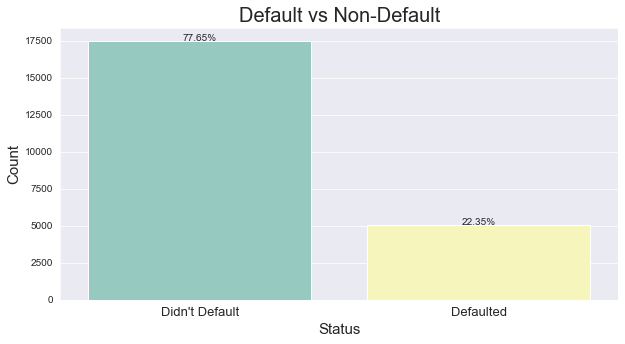

In [69]:
plt.figure(figsize = (10,5))
ax = sns.countplot(df['default'], palette='Set3')

ax.set_title('Default vs Non-Default',fontsize = 20)
ax.set_xlabel('Status',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Didn\'t Default','Defaulted'],fontsize = 13)

total = float(len(df)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 

plt.savefig('visualizations/class_imbalance.png', bbox_inches = "tight", pad_inches=.5)

As mentioned before, only 22% of people in this dataset defaulted on their credict card payment. Class imbalances such as this one can present challenges for the machine learning algorithm. Therefore, we can try to remedy this.

### We can deal with this class imbalance by just penalizing the algorithm with `weights = distance` for KNN and `class_weight = balanced` for Logistic Regression

## Evaluation Metric

For this business problem, we'll be using **F1 score** as the main evaluation metric. This metric is suited for datasets with class imbalance. Also, it's the harmonic mean of precision and recall. 

## Train-Test Split

In [70]:
# performing the TTS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

We can also apply a standard scaler to the data so that its magnitudes are normalized. This could help the learning algorithms and speed up calculations.

In [71]:
# instantiating scaler
scaler = StandardScaler()  
scaler.fit(X_train)

# applying scaler to data
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

## Model 1: K Nearest Neighbors

In [72]:
knn = KNeighborsClassifier(n_neighbors=6, weights='distance')

In [73]:
%%time
knn.fit(X_train, y_train)

CPU times: user 39.4 ms, sys: 4.41 ms, total: 43.8 ms
Wall time: 50.5 ms


KNeighborsClassifier(n_neighbors=6, weights='distance')

In [74]:
# predicting the training set
knn_y_pred_train = knn.predict(X_train)
# predicting the testing set
knn_tree_y_pred_test = knn.predict(X_test)

In [75]:
print('Untuned K Nearest Neighbors Model')
print("Training F1 Score: ", metrics.f1_score(y_train, knn_y_pred_train))
print("Testing F1 Score: ", metrics.f1_score(y_test, knn_tree_y_pred_test))

Untuned K Nearest Neighbors Model
Training F1 Score:  0.9993359011820959
Testing F1 Score:  0.424415832141154


It seems that this KNN model is way overfit and the testing metric isn't that great. Before addressing the overfitting, let's try to improve the testing metric with grid search. By optomizing the model's hyperparameters, the accuracy of predictions could improve.

### Grid Search

In [76]:
# creating estimator
k_near = KNeighborsClassifier(weights='distance')

In [77]:
# creating our parameters to test
k_param_dict={'n_neighbors': range(4,15,1)}

In [78]:
# create the instance of GridSearchCV using the F1 metric for our scoring
grid_k_neighbors = GridSearchCV(k_near, k_param_dict, cv=5, scoring='f1', verbose=1)

⏳ the cell below takes about 2 minutes to run

In [79]:
%%time
# fit the grid search to our data
grid_k_neighbors.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
CPU times: user 1min 57s, sys: 1.06 s, total: 1min 58s
Wall time: 2min
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  2.0min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(weights='distance'),
             param_grid={'n_neighbors': range(4, 15)}, scoring='f1', verbose=1)

In [80]:
# examine the best model
# Best F1 scoree achieved across all params
print('F1 Score:', grid_k_neighbors.best_score_)

# Checking dictionary showing the best hyperparameters used to generate that score
print('Best Hyperparameters:', grid_k_neighbors.best_params_)

# Actual model object fit with those best parameters
# also shows default parameters that we did not specify
print('Model object with best parameters: ')
print(grid_k_neighbors.best_estimator_)

F1 Score: 0.43350915712592125
Best Hyperparameters: {'n_neighbors': 14}
Model object with best parameters: 
KNeighborsClassifier(n_neighbors=14, weights='distance')


Grid search found that the 'best' KNN model has `n_neighbors` of 6. Let's take a look at the evaulation metrics of this model.

In [81]:
# Predict the response for test dataset
tuned_k_neighbors_y_pred_train = grid_k_neighbors.best_estimator_.predict(X_train)

# predict the training set
tuned_k_neighbors_y_pred_test = grid_k_neighbors.best_estimator_.predict(X_test)

# Model F1, how often is the classifier correct?
print('Tuned K Nearest Neighbors Predictions')
print("F1 on train set:",metrics.f1_score(y_train, tuned_k_neighbors_y_pred_train))
print("F1 on test set:",metrics.f1_score(y_test, tuned_k_neighbors_y_pred_test))

Tuned K Nearest Neighbors Predictions
F1 on train set: 0.9993359011820959
F1 on test set: 0.4361757105943152


This tuned model has a slightly better F1 score, improving from the previous 0.42. However it's stil severely overfit. Before anything trying anything else, we should investigate other baseline models. Next, let's test out how a Logistic Regression algorithm handles predictions.

## Model 2: Logisitic Regression

In [82]:
# instantiate
logreg = LogisticRegression(C=1e9, class_weight='balanced')

In [83]:
%%time
logreg.fit(X_train, y_train)

CPU times: user 292 ms, sys: 18.2 ms, total: 310 ms
Wall time: 107 ms


LogisticRegression(C=1000000000.0, class_weight='balanced')

In [84]:
# predict the training set
logreg_y_pred_train = logreg.predict(X_train)
# predict the testing set
logreg_y_pred_test = logreg.predict(X_test)

In [85]:
print('Untuned Logistic Regression Model')
print("Training F1 Score: ", metrics.f1_score(y_train, logreg_y_pred_train))
print("Testing F1 Score: ", metrics.f1_score(y_test, logreg_y_pred_test))

Untuned Logistic Regression Model
Training F1 Score:  0.525810028335592
Testing F1 Score:  0.5414847161572053


Right off the bat, this model performed much better than the other KNN models. It's not overfit and it has a higher F1 on the testing set. To get a better sense of the model's performance, let's also look at the ROC/AUC score.

In [86]:
# getting probabilities for the target in array form
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

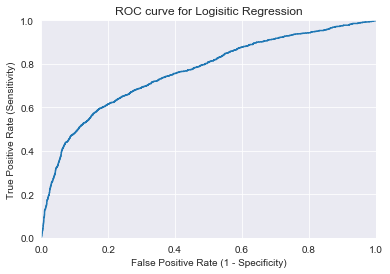

In [87]:
# ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logisitic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [88]:
# Generating AUC
print(metrics.roc_auc_score(y_test, y_pred_prob))
# print('AUC: {}'.format(auc(fpr, tpr)))

0.7648104562526212


Ideally, we want an ROC that hugs the upper left corner of the graph. So, the ROC curve for this model isn't too bad! And a perfect AUC score would be 1. Therefore, this model's predictions are only about 76.48% correct.

Finally, we can look at the other evaluation metrics for this model and generate a confusion matrix to get a visual breakdown on how the model is predicting each model.

In [89]:
# # y_true = y_test (ground truth/ correct target values)
# # y_pred = logreg_y_pred_test (estimated targets as returned by classifier)

# confusion = metrics.confusion_matrix(y_test, logreg_y_pred_test)
# TN = confusion[0, 0]
# FP = confusion[0, 1]
# FN = confusion[1, 0]
# TP = confusion[1, 1]

In [90]:
# # print(metrics.confusion_matrix(y_test, y_pred_class))
# confusion

In [91]:
# # formula for accuracy
# print((TP + TN) / float(TP + TN + FP + FN))
# # metrics.accuracy_score(y_test, logreg_y_pred_test)

In [92]:
# print(metrics.classification_report(y_test, logreg_y_pred_test))

In [93]:
print('accuracy:', metrics.accuracy_score(y_test, logreg_y_pred_test))
print('precision:', metrics.precision_score(y_test, logreg_y_pred_test))
print('recall:', metrics.recall_score(y_test, logreg_y_pred_test))
print('f1 score:', metrics.f1_score(y_test, logreg_y_pred_test))

accuracy: 0.776
precision: 0.5003362474781439
recall: 0.5900079302141158
f1 score: 0.5414847161572053


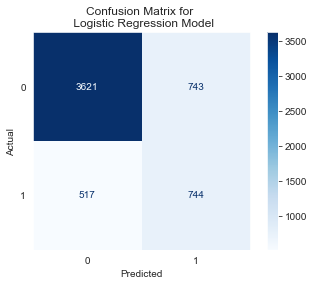

In [124]:
log_reg_conf_matrix = plot_confusion_matrix(logreg, X_test, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Blues)
log_reg_conf_matrix.ax_.set_title('Confusion Matrix for \n Logistic Regression Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)

With this confusion matrix, we can see that the model predicts the 'Non-Default' label pretty well! However, it's not as strong with predicting 'Default'. Let's normalize this confusion matrix too.

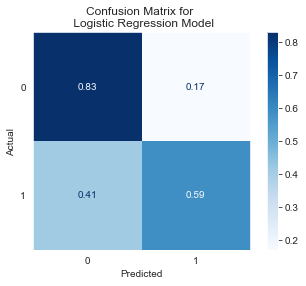

In [125]:
normalized_log_reg_conf_matrix = plot_confusion_matrix(logreg, X_test, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
normalized_log_reg_conf_matrix.ax_.set_title('Normalized Confusion Matrix for \n Logistic Regression Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)

As mentioned, the Recall (TRP) of this model isn't the best. We can try improving this model from here.

## Grid Search

Logistic Regression models don't have many hyperparameters to tune, but it's worth a shot to see if we can improve the evaluation metrics a bit.

In [95]:
# creating our estimator
tuned_log = LogisticRegression(random_state=6, class_weight='balanced')

In [96]:
# creating our parameters to test
log_param_dict={'C': range(3,7,1),
                'penalty': ['l1','l2']}

In [97]:
grid_log = GridSearchCV(tuned_log, log_param_dict, cv=5, scoring='f1', verbose=1)

In [98]:
%%time
grid_log.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
CPU times: user 4.82 s, sys: 98.1 ms, total: 4.92 s
Wall time: 1.3 s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.2s finished


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=6),
             param_grid={'C': range(3, 7), 'penalty': ['l1', 'l2']},
             scoring='f1', verbose=1)

In [99]:
# examine the best model
print('F1 Score:', grid_log.best_score_)
print('Best Hyperparameters:', grid_log.best_params_)
print('Model object with best parameters: ')
print(grid_log.best_estimator_)

F1 Score: 0.5230355488559063
Best Hyperparameters: {'C': 3, 'penalty': 'l2'}
Model object with best parameters: 
LogisticRegression(C=3, class_weight='balanced', random_state=6)


So this grid search yielded a model with a `C` of 3. Also, the L2 regularization is the default option, according to scikit-learn's documentation.

In [100]:
# predict the testing dataset
grid_log_y_pred_train = grid_log.best_estimator_.predict(X_train)

# predict the training set
grid_log_y_pred_test = grid_log.best_estimator_.predict(X_test)

# Model F1, how often is the classifier correct?
print('Tuned Logistic Regression Model Predictions')
print("F1 on train set:",metrics.f1_score(y_train, grid_log_y_pred_train))
print("F1 on test set:",metrics.f1_score(y_test, grid_log_y_pred_test))

Tuned Logistic Regression Model Predictions
F1 on train set: 0.525810028335592
F1 on test set: 0.5414847161572053


This model actually generated the same exact evaluation metrics as the baseline Logistic Regression model. As I mentioned before, this is probably because Logistic Regression models don't have many hyperparameters to tune. Therefore, there wasn't much difference between the baseline and tuned models.

Lastly, let's try out a Decision Tree model to see if the F1 score improves at all.

## Model 3: Decision Tree

In [101]:
# baseline decision tree
tree = DecisionTreeClassifier()

In [102]:
%%time
tree.fit(X_train, y_train)

CPU times: user 491 ms, sys: 10.4 ms, total: 501 ms
Wall time: 348 ms


DecisionTreeClassifier()

In [103]:
# predict the training set
tree_y_pred_train = tree.predict(X_train)
# predict the testing set
tree_y_pred_test = tree.predict(X_test)

In [104]:
print('Untuned Decision Tree Model')
print("Training F1 Score: ", metrics.f1_score(y_train, tree_y_pred_train))
print("Testing F1 Score: ", metrics.f1_score(y_test, tree_y_pred_test))

Untuned Decision Tree Model
Training F1 Score:  0.9993359011820959
Testing F1 Score:  0.37509667440061867


Unfortunately, the baseline Decision Tree model performed much worse than the other model iterations. It's also severely overfit. Let's see if we can improve this with grid search.

It's important to note that baseline models for tree-based algorithms will always be overfit like this because we never told it when to "stop." This can be solved with the hyperparamter `max_leaf_nodes`.

## Grid Search

In [105]:
# creating our estimator
decision_tree = DecisionTreeClassifier(random_state=3, criterion='gini')

In [106]:
# creating our parameters to test
param_dict={'max_depth': range(2,15,1), 
            'max_leaf_nodes': range(2,30,2),
            'min_samples_split': range(2,4,1)}

In [107]:
# create the instance of GridSearchCV using the F1 metric for our scoring. 
grid_tree = GridSearchCV(decision_tree, param_dict, cv=5, scoring='f1', verbose=1)

In [108]:
%%time
# fit the grid search to our data
grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 364 candidates, totalling 1820 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
CPU times: user 2min 24s, sys: 1.4 s, total: 2min 25s
Wall time: 2min 27s
[Parallel(n_jobs=1)]: Done 1820 out of 1820 | elapsed:  2.5min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=3),
             param_grid={'max_depth': range(2, 15),
                         'max_leaf_nodes': range(2, 30, 2),
                         'min_samples_split': range(2, 4)},
             scoring='f1', verbose=1)

In [109]:
# examine the best model
# Best F1 scoree achieved across all params
print('F1 Score:', grid_tree.best_score_)
# Checking dictionary showing the best hyperparameters used to generate that score
print('Best Hyperparameters:', grid_tree.best_params_)
# Actual model object fit with those best parameters
# also shows default parameters that we did not specify
print('Model object with best parameters: ')
print(grid_tree.best_estimator_)

F1 Score: 0.47466865343357495
Best Hyperparameters: {'max_depth': 4, 'max_leaf_nodes': 12, 'min_samples_split': 2}
Model object with best parameters: 
DecisionTreeClassifier(max_depth=4, max_leaf_nodes=12, random_state=3)


In [110]:
# predict the testing set
tuned_tree_y_pred_train = grid_tree.best_estimator_.predict(X_train)

# predict the training set
tuned_tree_y_pred_test = grid_tree.best_estimator_.predict(X_test)

# Model F1, how often is the classifier correct?
print('Tuned Decision Tree Model Predictions')
print("F1 on train set:",metrics.f1_score(y_train, tuned_tree_y_pred_train))
print("F1 on test set:",metrics.f1_score(y_test, tuned_tree_y_pred_test))

Tuned Decision Tree Model Predictions
F1 on train set: 0.48081225262433314
F1 on test set: 0.48879837067209775


We were able to solve the overfitting issue. Unfortunately, this F1 score isn't as high as .541 on the Logistic Regression model. Let's try one last model before sticking with the Logistic Regression model.

## Model 4: Random Forest

Instead of creating a baseline Random Forest model, we can jump into performing grid search. This is because a Random Forest algorithm is essentially an ensamble method with tons of Decision Trees. Therefore, our initial Decision Tree is technically the baseline already.

In [111]:
rfc = RandomForestClassifier(random_state = 5, criterion='gini' , class_weight='balanced')

In [112]:
# creating our parameters to test
rfc_param_dict={'n_estimators':[50,100],
            'max_depth': list(range(2,15)), 
            'max_features': list(range(5,15))
            }

In [113]:
# create a grid search object and fit it to the data
grid_forest = GridSearchCV(rfc, rfc_param_dict, cv=5, scoring='f1', verbose=1, n_jobs=2)

In [ ]:
⏳ the cell below takes about 23 minutes to run

In [114]:
%%time
grid_forest.fit(X_train, y_train)

Fitting 5 folds for each of 260 candidates, totalling 1300 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 10.3min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed: 20.8min
[Parallel(n_jobs=2)]: Done 1300 out of 1300 | elapsed: 22.5min finished
CPU times: user 10.3 s, sys: 562 ms, total: 10.9 s
Wall time: 22min 33s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=5),
             n_jobs=2,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14],
                         'max_features': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'n_estimators': [50, 100]},
             scoring='f1', verbose=1)

In [115]:
print(grid_forest.best_score_)
print(grid_forest.best_params_)
print(grid_forest.best_estimator_)

0.5399529757163821
{'max_depth': 4, 'max_features': 7, 'n_estimators': 100}
RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=7,
                       random_state=5)


In [116]:
# Predict the response for test dataset
forest_y_pred_train = grid_forest.best_estimator_.predict(X_train)

# predict the training set
forest_y_pred_test = grid_forest.best_estimator_.predict(X_test)

# Model F1, how often is the classifier correct?
print("F1 on train set: ",metrics.f1_score(y_train, forest_y_pred_train))
print("F1 on test set: ",metrics.f1_score(y_test, forest_y_pred_test))

F1 on train set:  0.546448087431694
F1 on test set:  0.5411937019406812


This Random Forest model performed the best out of all the model iterations. This will be the final model, so let's perform some analysis on how it is able to predict each label.

## 6. Final Model

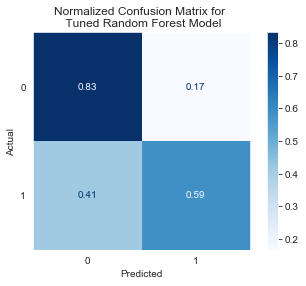

In [127]:
normalized_forest_conf_matrix = plot_confusion_matrix(grid_forest, X_test, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
normalized_forest_conf_matrix.ax_.set_title('Normalized Confusion Matrix for \n Tuned Random Forest Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.savefig('./visualizations/normalized_forest_matrix.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

This model is able to correctly predict the 'default' label 59% of the time. Although this isn't an ideal metric, it's the best under the contraints of this project. Simple classification algorithms such as these typically don't perform well with imbalanced data. And a next step would be to try more complex algorithms such as neural networks.

### Refitting Model to the Entire Dataframe

In [117]:
features = df.drop('default', axis = 1)
# Create target variable
target = df['default'] # y is the column we're trying to pred

In [118]:
best_model = RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=7, random_state=5)

In [119]:
best_model = best_model.fit(features,target)

## 7. Exporting with Pickle

Next, we can export the final model with Pickle and use it to predict on the holdout set. Please refer to `predict_holdout.ipynb` to view that process.

In [120]:
# pickling final model
pickle_out = open("pickle/final_model.pickle","wb")
pickle.dump(best_model, pickle_out)
pickle_out.close()

In [121]:
# pickling scalar
scaler_pickle_out = open("pickle/final_scaler.pickle","wb")
pickle.dump(scaler, scaler_pickle_out)
scaler_pickle_out.close()